In [1]:
import sys
import os
if os.getcwd().endswith('notebooks'):
    os.chdir("..")
print(os.getcwd())
from importlib import reload

/Users/brielle/Documents/Python/Detect-Who-Is-Talking


## Imports

In [173]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import librosa.display
from scipy.io import wavfile as wav
import IPython.display as ipd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import detect_who_is_talking.data_preparation as dp
import detect_who_is_talking.model_creation as mc

### Listen to 1 Audio example

In [3]:
filepath = os.path.join('data', 'test_audios', '836_SofiaF1.wav')
ipd.Audio(filepath)

### View a visual representation of the audio

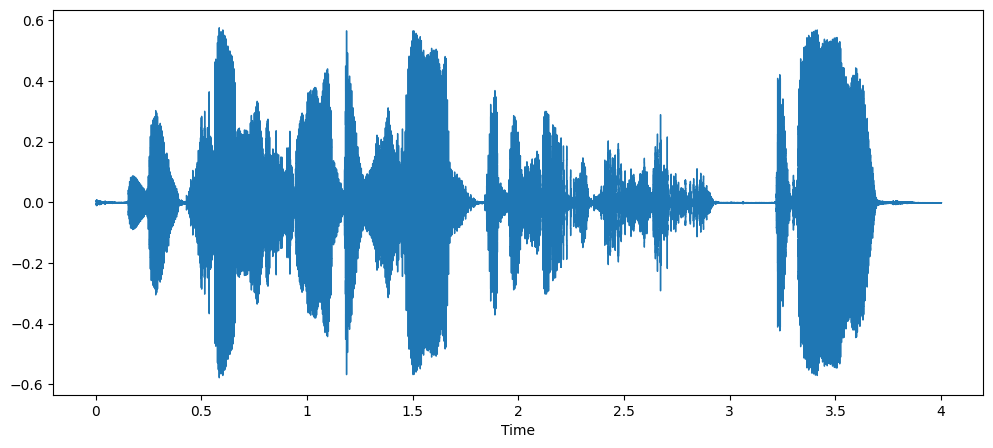

In [4]:
data, sample_rate = librosa.load(filepath)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(data, sr=sample_rate)

# Data 

## Steps 1, 2, 3 are not necessary if you already have all your data

### 1 - Split a long audio file into shorter audio files

In [ ]:
reload(dp)
# dp.split_audio_into_files(
#     long_audio_path=os.path.join('data','podcast_4.wav'), 
#     short_audios_folder=os.path.join('data', 'Bill_Burr'), 
#     sec_per_split=4
# )

### 2 - Get audio features from folder of little audio files

In [22]:
reload(dp)
# new_df = dp.create_df_from_audio_files(
#     os.path.join('data', 'Bill_Burr'), 
#     class_='Bill Burr'
# )

### 3 - Add the new audio features df with the previous data

In [ ]:
reload(dp)
# df = dp.append_new_data_to_df(new_df, save_to_csv=False)

## Import the data

In [214]:
reload(dp)
csv_path = os.path.join('data', 'voice_audio_arrays_quarter.csv')
df = pd.read_csv(csv_path).sample(frac=1).reset_index(drop=True)
df['feature'] = df['feature'].map(lambda x: dp.prepare_df_for_model(str(x)))
df

,feature,class
0,"[-313.39978, 62.690434, -25.013672, 23.627176,...",Sofia Franklyn
1,"[-399.464325, 75.385994, -3.44175196, 17.38704...",Sarah Silverman
2,"[-403.6473, 72.57204, 10.607204, 28.333424, 7....",Andrew Santino
3,"[-347.68835, 91.467834, -12.594923, 44.133362,...",Bill Burr
4,"[-309.37653, 45.142517, -16.651064, 33.94902, ...",Sarah Silverman
...,...,...
1967,"[-327.23676, 77.105507, -24.234589, 3.9801075,...",Sofia Franklyn
1968,"[-321.207428, 37.6796417, -13.3795385, 16.8325...",Sarah Silverman
1969,"[-342.59201, 78.109253, -39.803497, 30.950308,...",Bill Burr
1970,"[-260.268463, 77.2722778, -32.015995, 25.57736...",Sofia Franklyn


In [215]:
df['class'].value_counts()

Andrew Santino     506
Bill Burr          491
Sofia Franklyn     490
Sarah Silverman    485
Name: class, dtype: int64

### Optional: If the classes are crazy unbalanced we can remove some rows of a class that has too many

In [ ]:
# Say we want to remove 600 rows of Andrew Santino Class we can do this
class_to_drop = 'Andrew Santino'
n_rows_to_drop = 600
#+++++++++++++++++++++++++++++
# indexes_to_drop = list(df[df['class']==class_to_drop].sample(n=n_rows_to_drop).index)
# df = df.drop(index=indexes_to_drop).reset_index(drop=True)
# print(df.shape)
# Check if the classes are more balanced now
# df['class'].value_counts()

## Train Test Split

In [216]:
# Split the dataset into independent and dependent dataset
X = np.array(df['feature'].tolist())
y = np.array(df['class'].tolist())
# Label Encoding -> Label Encoder 
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [145]:
y_train

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

# Model

## Design the Model

In [210]:
# No of classes
num_labels = y.shape[1]
model = Sequential()
# first layer
model.add(Dense(100, input_shape=(40, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [211]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Train the Model

In [212]:
# Training the model
num_epochs = 100
num_batch_size = 32
#+++++++++++++++++++++++++++++++++++++++
checkpointer = ModelCheckpoint(
    filepath=os.path.join('models', 'audio_classification_model.hdf5'), 
    verbose=1, 
    save_best_only=True
)
start = datetime.now()
model.fit(
    X_train, y_train, 
    batch_size=num_batch_size, epochs=num_epochs, 
    validation_data=(X_test, y_test), 
    callbacks=[checkpointer], # Change this to None if we don't want to save the model
    verbose=1
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
40/50 [=======================>......] - ETA: 0s - loss: 26.5835 - accuracy: 0.2422
Epoch 1: val_loss improved from inf to 1.74696, saving model to data/audio_classification_model.hdf5
50/50 [==============================] - 2s 10ms/step - loss: 24.1649 - accuracy: 0.2448 - val_loss: 1.7470 - val_accuracy: 0.2861
Epoch 2/100
46/50 [==========================>...] - ETA: 0s - loss: 7.9402 - accuracy: 0.2914
Epoch 2: val_loss improved from 1.74696 to 1.28420, saving model to data/audio_classification_model.hdf5
50/50 [==============================] - 0s 6ms/step - loss: 7.7598 - accuracy: 0.2923 - val_loss: 1.2842 - val_accuracy: 0.2911
Epoch 3/100
43/50 [========================>.....] - ETA: 0s - loss: 4.2799 - accuracy: 0.2994
Epoch 3: val_loss did not improve from 1.28420
50/50 [==============================] - 0s 5ms/step - loss: 4.1747 - accuracy: 0.3044 - val_loss: 1.3471 - val_accuracy: 0.3924
Epoch 4/100
35/50 [====================>.........] - ETA: 0s - loss: 2.7

37/50 [=====================>........] - ETA: 0s - loss: 0.5787 - accuracy: 0.7660
Epoch 27: val_loss improved from 0.34240 to 0.34090, saving model to data/audio_classification_model.hdf5
50/50 [==============================] - 0s 5ms/step - loss: 0.5720 - accuracy: 0.7717 - val_loss: 0.3409 - val_accuracy: 0.9190
Epoch 28/100
35/50 [====================>.........] - ETA: 0s - loss: 0.5654 - accuracy: 0.7777
Epoch 28: val_loss improved from 0.34090 to 0.27174, saving model to data/audio_classification_model.hdf5
50/50 [==============================] - 0s 5ms/step - loss: 0.5400 - accuracy: 0.7901 - val_loss: 0.2717 - val_accuracy: 0.9443
Epoch 29/100
37/50 [=====================>........] - ETA: 0s - loss: 0.4851 - accuracy: 0.8159
Epoch 29: val_loss improved from 0.27174 to 0.21867, saving model to data/audio_classification_model.hdf5
50/50 [==============================] - 0s 5ms/step - loss: 0.5101 - accuracy: 0.8110 - val_loss: 0.2187 - val_accuracy: 0.9544
Epoch 30/100
35/50 [

50/50 [==============================] - 0s 4ms/step - loss: 0.1408 - accuracy: 0.9524 - val_loss: 0.0324 - val_accuracy: 0.9873
Epoch 54/100
33/50 [==================>...........] - ETA: 0s - loss: 0.1933 - accuracy: 0.9536
Epoch 54: val_loss did not improve from 0.03012
50/50 [==============================] - 0s 4ms/step - loss: 0.1754 - accuracy: 0.9543 - val_loss: 0.0378 - val_accuracy: 0.9899
Epoch 55/100
37/50 [=====================>........] - ETA: 0s - loss: 0.1343 - accuracy: 0.9662
Epoch 55: val_loss improved from 0.03012 to 0.02745, saving model to data/audio_classification_model.hdf5
50/50 [==============================] - 0s 5ms/step - loss: 0.1455 - accuracy: 0.9664 - val_loss: 0.0275 - val_accuracy: 0.9899
Epoch 56/100
35/50 [====================>.........] - ETA: 0s - loss: 0.1533 - accuracy: 0.9509
Epoch 56: val_loss did not improve from 0.02745
50/50 [==============================] - 0s 4ms/step - loss: 0.1489 - accuracy: 0.9512 - val_loss: 0.0368 - val_accuracy: 0

50/50 [==============================] - 0s 4ms/step - loss: 0.0743 - accuracy: 0.9772 - val_loss: 0.0211 - val_accuracy: 0.9924
Epoch 83/100
37/50 [=====================>........] - ETA: 0s - loss: 0.0909 - accuracy: 0.9747
Epoch 83: val_loss did not improve from 0.01830
50/50 [==============================] - 0s 4ms/step - loss: 0.0904 - accuracy: 0.9759 - val_loss: 0.0217 - val_accuracy: 0.9899
Epoch 84/100
37/50 [=====================>........] - ETA: 0s - loss: 0.0713 - accuracy: 0.9738
Epoch 84: val_loss did not improve from 0.01830
50/50 [==============================] - 0s 4ms/step - loss: 0.0779 - accuracy: 0.9740 - val_loss: 0.0184 - val_accuracy: 0.9899
Epoch 85/100
38/50 [=====================>........] - ETA: 0s - loss: 0.0747 - accuracy: 0.9745
Epoch 85: val_loss did not improve from 0.01830
50/50 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.9746 - val_loss: 0.0210 - val_accuracy: 0.9924
Epoch 86/100
33/50 [==================>...........] 

## View Model Accuracy

In [213]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.9924050569534302


In [199]:
predict_x = model.predict(X_test) 
classes_x = np.argmax(predict_x, axis=1)
print(classes_x)

13/13 [==============================] - 0s 2ms/step
[3 3 2 2 0 0 2 3 3 2 0 0 2 0 2 1 0 1 1 2 2 2 0 0 3 2 3 3 3 1 3 3 2 3 2 3 2
 0 0 1 2 2 0 3 1 1 1 0 1 3 0 1 1 3 3 0 0 2 0 0 2 2 1 0 1 0 2 1 3 3 1 0 2 0
 1 3 0 2 2 2 2 1 2 0 0 0 3 0 2 2 1 3 0 1 2 3 0 1 3 1 0 1 1 3 1 1 2 3 0 3 2
 3 3 2 0 1 0 0 2 3 0 0 1 0 2 3 3 3 3 2 3 2 1 0 3 2 0 3 2 3 2 0 0 0 2 3 1 0
 2 0 2 0 2 1 3 1 1 1 2 1 0 1 3 2 2 2 1 1 3 2 2 2 1 3 0 3 2 0 0 1 2 1 3 0 1
 3 3 3 2 0 3 3 2 1 0 3 1 3 3 2 3 0 3 1 0 0 3 0 2 1 3 1 0 0 2 2 1 3 0 2 0 3
 1 1 1 3 2 0 0 3 3 3 0 3 2 1 0 2 3 3 1 2 2 1 1 2 0 0 1 2 3 2 3 3 0 0 2 3 1
 2 2 1 1 1 3 1 2 2 2 0 0 0 0 2 2 3 2 3 0 2 2 1 2 0 0 0 0 3 3 2 2 3 0 0 1 1
 0 2 2 2 2 1 1 1 3 0 1 3 3 0 0 0 3 2 2 3 2 2 3 3 0 3 1 2 1 0 0 2 2 0 3 1 0
 2 2 0 3 0 3 0 2 1 3 1 1 2 3 2 1 2 3 0 0 1 0 1 2 0 1 1 2 0 2 1 2 1 2 1 1 2
 2 0 2 1 3 3 3 3 2 0 2 2 2 1 2 3 3 3 2 1 2 3 2 1 0]


# Test

In [151]:
os.listdir(os.path.join('data', 'test_audios'))

['3692_Santino2.wav',
 '2012_SarahS2.wav',
 '3012_BillBurr2.wav',
 '2620_Santino3.wav',
 '1736_SofiaF2.wav',
 '3188_SofiaF1.wav',
 '16_SofiaF1.wav',
 '.DS_Store',
 '2396_SarahS3.wav',
 '3648_Santino3.wav',
 '2816_SarahS1.wav',
 '3272_Santino1.wav',
 '2224_SarahS1.wav',
 '880_SarahS3.wav',
 '836_SofiaF1.wav',
 '160_Santino3.wav',
 '2356_SarahS3.wav',
 '3032_BillBurr2.wav',
 '1280_Santino1.wav',
 '440_SofiaF2.wav',
 '20_SarahS1.wav',
 '24_BillBurr2.wav',
 '2540_SarahS2.wav',
 '1840_SofiaF2.wav',
 '3628_Santino2.wav',
 '60_BillBurr2.wav',
 '756_SofiaF2.wav',
 '1604_SofiaF2.wav',
 '2036_Santino2.wav',
 '628_BillBurr2.wav']

In [191]:
# Which file do we want to predict?
filename = os.path.join('data', 'test_audios', '3012_BillBurr2.wav')
ipd.Audio(filename)

In [192]:
# preprocess the audio file
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
# Reshape MFCC feature to 2-D array
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)
# predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model.predict(mfccs_scaled_features) 
predicted_label=np.argmax(x_predict, axis=1)
# print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(f'\nPrediction is: {prediction_class[0]}')

1/1 [==============================] - 0s 25ms/step

Prediction is: Bill Burr


### For fun we can view what the audio looks like

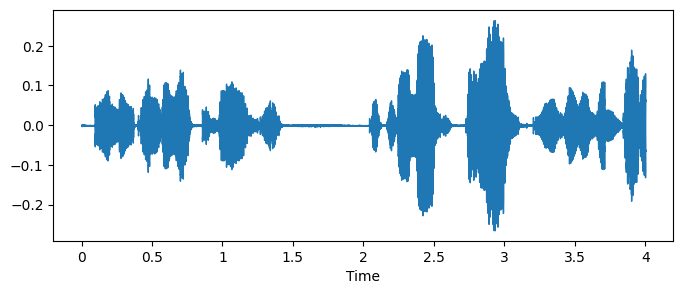

In [193]:
data, sample_rate = librosa.load(filename)
plt.figure(figsize=(8, 3))
librosa.display.waveshow(data, sr=sample_rate)